In [13]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
!pip install rdkit
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, median_absolute_error, max_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy.stats import randint
from scipy.stats import uniform
from torch.utils.data import TensorDataset, DataLoader

!pip install skorch
import skorch
from skorch import NeuralNetClassifier

!pip install chembl_webresource_client

from chembl_webresource_client.new_client import new_client

selection = VarianceThreshold(threshold=(.8 * (1 - .8)))

In [14]:
from google.colab import files

# This will prompt you to select a file from your local filesystem
uploaded = files.upload()

Saving fcn_model.joblib to fcn_model (1).joblib
Saving rf_model.joblib to rf_model (1).joblib
Saving svm_model.joblib to svm_model (1).joblib


# Importing all the packages needed

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import rdkit
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, median_absolute_error, max_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
#import keras_tuner as kt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from scipy.stats import randint
from scipy.stats import uniform
from torch.utils.data import TensorDataset, DataLoader

import skorch
from skorch import NeuralNetClassifier

from chembl_webresource_client.new_client import new_client

selection = VarianceThreshold(threshold=(.8 * (1 - .8)))

In [19]:
from joblib import dump, load

# Choosing the what is our Target protein: mTor is a good candidate

In [20]:
target = new_client.target
target_query = target.search('mTor')
possible_targets = pd.DataFrame.from_dict(target_query)
possible_targets.head()


,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P42346', 'xref_name': None, 'xre...",Rattus norvegicus,Serine/threonine-protein kinase mTOR,15.0,False,CHEMBL1075134,"[{'accession': 'P42346', 'component_descriptio...",SINGLE PROTEIN,10116
1,[],Mus musculus,Serine/threonine-protein kinase mTOR,15.0,False,CHEMBL1255165,"[{'accession': 'Q9JLN9', 'component_descriptio...",SINGLE PROTEIN,10090
2,[],Homo sapiens,DEPTOR/mTOR,15.0,False,CHEMBL4523674,"[{'accession': 'P42345', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
3,"[{'xref_id': 'P42345', 'xref_name': None, 'xre...",Homo sapiens,Serine/threonine-protein kinase mTOR,14.0,False,CHEMBL2842,"[{'accession': 'P42345', 'component_descriptio...",SINGLE PROTEIN,9606
4,"[{'xref_id': 'Q6R327', 'xref_name': None, 'xre...",Homo sapiens,Rapamycin-insensitive companion of mTOR,14.0,False,CHEMBL1795179,"[{'accession': 'Q6R327', 'component_descriptio...",SINGLE PROTEIN,9606


In [21]:
target = possible_targets.target_chembl_id[3]

In [22]:
activity = new_client.activity
res = activity.filter(target_chembl_id=target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)
df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,866953,[],CHEMBL682171,The inhibitory activity by using FK506 binding...,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase mTOR,9606,None,None,Log IC50,None,UO_0000065,None,-5.0
1,None,None,868131,[],CHEMBL682171,The inhibitory activity by using FK506 binding...,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase mTOR,9606,None,None,Log IC50,None,UO_0000065,None,-5.0
2,None,None,873239,[],CHEMBL682171,The inhibitory activity by using FK506 binding...,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase mTOR,9606,None,None,Log IC50,None,UO_0000065,None,-5.0
3,None,None,873240,[],CHEMBL677281,The inhibitory activity by using FK506 binding...,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase mTOR,9606,None,None,Log IC50,None,UO_0000065,None,-8.5
4,None,None,875431,[],CHEMBL682171,The inhibitory activity by using FK506 binding...,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase mTOR,9606,None,None,Log IC50,None,UO_0000065,None,-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5173,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25044933,[],CHEMBL5245709,Inhibition of human mTOR,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase mTOR,9606,None,None,IC50,nM,UO_0000065,None,0.1
5174,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25072205,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5253274,Inhibition of mTOR (unknown origin) incubated ...,B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase mTOR,9606,None,None,IC50,nM,UO_0000065,None,39.0
5175,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25072220,[],CHEMBL5253279,Inhibition of mTOR (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase mTOR,9606,None,None,IC50,nM,UO_0000065,None,2.4
5176,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25073472,[],CHEMBL5253692,Inhibition of mTOR (unknown origin),B,None,None,BAO_0000190,...,Homo sapiens,Serine/threonine-protein kinase mTOR,9606,None,None,IC50,nM,UO_0000065,None,280.0


# Data cleaning & preparation

## Keeping only interesting entries for our models and suppression of incomplete data

In [24]:
df_clean = data_cleaner(df)
df_clean

<ipython-input-23-36e99160bab2>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataframe_cleaned = dataframe_cleaned[dataframe.canonical_smiles.notna()]


,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL269775,CC(CN1CCCCC1)OC(=O)[C@@H]1CCCN1C(=O)C(=O)C(C)(C)C,10000.0
1,CHEMBL6683,CC(CN1CCCCC1)OC(=O)[C@@H]1CCCN1C(=O)C(=O)c1ccccc1,10000.0
2,CHEMBL7237,CC(C)CC(=O)C(=O)N1CCC[C@H]1C(=O)OCCCc1cccnc1,10000.0
3,CHEMBL269732,C=CC[C@@H]1/C=C(\C)C[C@H](C)C[C@H](OC)[C@H]2O[...,3.162
4,CHEMBL266660,CC(C)CC(=O)C(=O)N1CCC[C@H]1C(=O)OCCS(=O)(=O)c1...,10000.0
...,...,...,...
5165,CHEMBL2333366,O=C(c1ccc(C(=O)C(F)(F)F)cc1)N1CCOc2ccc(-c3cnc4...,95.0
5168,CHEMBL5274669,COc1ccc(C2Cc3c(C)nc(N)nc3N([C@H]3CC[C@H](OCCO)...,16.0
5169,CHEMBL5276168,C[C@H]1COCCN1c1nc(-c2ccc(NC(=O)NCC(F)F)cc2)cc(...,1000.0
5170,CHEMBL5271617,CCOC(=O)N1Cc2nc(-c3ccc(NC(=O)NC4CC4)cc3)nc(N3C...,1000.0


## Labeling of the bioactivity of the different molecules

Text(0, 0.5, 'Frequency')

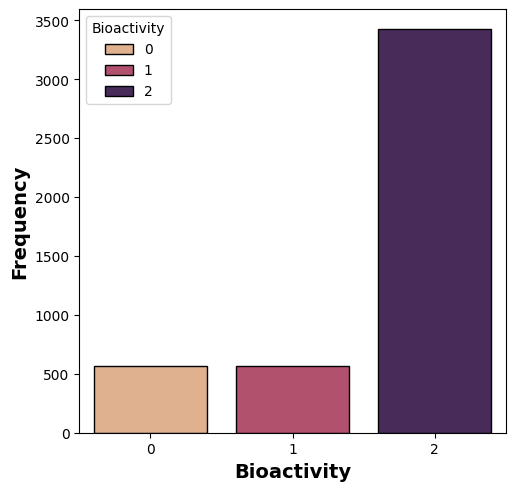

In [25]:
df_label = add_bioactivity(df_clean)
#df_label

plt.figure(figsize=(5.5, 5.5))
#sns.color_palette("flare")
sns.countplot(x='Bioactivity', hue = 'Bioactivity', data=df_label, edgecolor='black', palette = "flare")

plt.xlabel('Bioactivity', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

The dataset is not really well equilibrated, let's do some data augmentation!

## Data Augmentation

,molecule_chembl_id,canonical_smiles,standard_value,Bioactivity
0,CHEMBL269732,C=CC[C@@H]1/C=C(\C)C[C@H](C)C[C@H](OC)[C@H]2O[...,3.162,2
1,CHEMBL413,CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(...,3.467,2
2,CHEMBL411735,C=CC[C@@H]1/C=C(\C)C[C@H](C)C[C@H](OC)C2C[C@@]...,1.45,2
3,CHEMBL265123,C=CC[C@@H]1/C=C(\C)C[C@H](C)C[C@H](OC)C2C[C@@]...,1.88,2
4,CHEMBL428496,COC[C@H]1OC(=O)c2coc3c2[C@@]1(C)C1=C(C3=O)[C@@...,40.0,2
...,...,...,...,...
10204,CHEMBL5286283,C1(=C\c2ccc(NS(c3ccc(c(C)c3)[N+]([O-])=O)(=O)=...,8230.0,1
10205,CHEMBL5286283,c1cc(S(=O)(Nc2ccc(cc2)/C=C2/C(N(CC3(CCCCC3)C)C...,8230.0,1
10206,CHEMBL5286283,[O-][N+](c1c(C)cc(S(=O)(=O)Nc2ccc(cc2)/C=C2/C(...,8230.0,1
10207,CHEMBL5286283,O=S(c1ccc(c(c1)C)[N+](=O)[O-])(Nc1ccc(/C=C2/C(...,8230.0,1


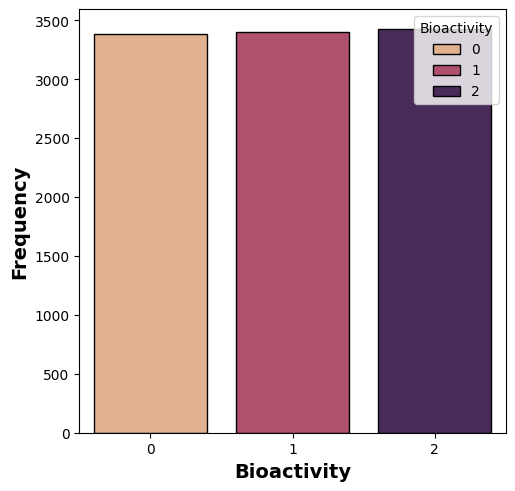

In [26]:
filtered_df = df_label[df_label['Bioactivity'].isin([0, 1])]


augmented_df = augment_data(filtered_df, num_augments=5)
combined_df = pd.concat([filtered_df, augmented_df])

df_bioactive = df_label[df_label['Bioactivity'].isin([2])]

df = pd.concat([df_bioactive, combined_df])



plt.figure(figsize=(5.5, 5.5))
#sns.color_palette("flare")
sns.countplot(x='Bioactivity', hue = 'Bioactivity', data=df, edgecolor='black', palette = "flare")

plt.xlabel('Bioactivity', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

df = df.reset_index(drop=True)
df

## Definition of the Lipinski descriptor

In [27]:
df_lipinski = lipinski_df(df)
df_lipinski

,molecule_chembl_id,canonical_smiles,Bioactivity,Mw,H donors,H acceptors,Log P,pIC50
0,CHEMBL269732,C=CC[C@@H]1/C=C(\C)C[C@H](C)C[C@H](OC)[C@H]2O[...,2,804.031,3,12,4.63900,8.500038
1,CHEMBL413,CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(...,2,914.187,3,13,6.18060,8.460046
2,CHEMBL411735,C=CC[C@@H]1/C=C(\C)C[C@H](C)C[C@H](OC)C2C[C@@]...,2,1021.343,3,13,8.16230,8.838632
3,CHEMBL265123,C=CC[C@@H]1/C=C(\C)C[C@H](C)C[C@H](OC)C2C[C@@]...,2,1007.316,4,12,8.07390,8.725842
4,CHEMBL428496,COC[C@H]1OC(=O)c2coc3c2[C@@]1(C)C1=C(C3=O)[C@@...,2,428.437,0,8,2.53640,7.397940
...,...,...,...,...,...,...,...,...
10204,CHEMBL5286283,C1(=C\c2ccc(NS(c3ccc(c(C)c3)[N+]([O-])=O)(=O)=...,1,529.640,1,7,5.71072,5.084600
10205,CHEMBL5286283,c1cc(S(=O)(Nc2ccc(cc2)/C=C2/C(N(CC3(CCCCC3)C)C...,1,529.640,1,7,5.71072,5.084600
10206,CHEMBL5286283,[O-][N+](c1c(C)cc(S(=O)(=O)Nc2ccc(cc2)/C=C2/C(...,1,529.640,1,7,5.71072,5.084600
10207,CHEMBL5286283,O=S(c1ccc(c(c1)C)[N+](=O)[O-])(Nc1ccc(/C=C2/C(...,1,529.640,1,7,5.71072,5.084600


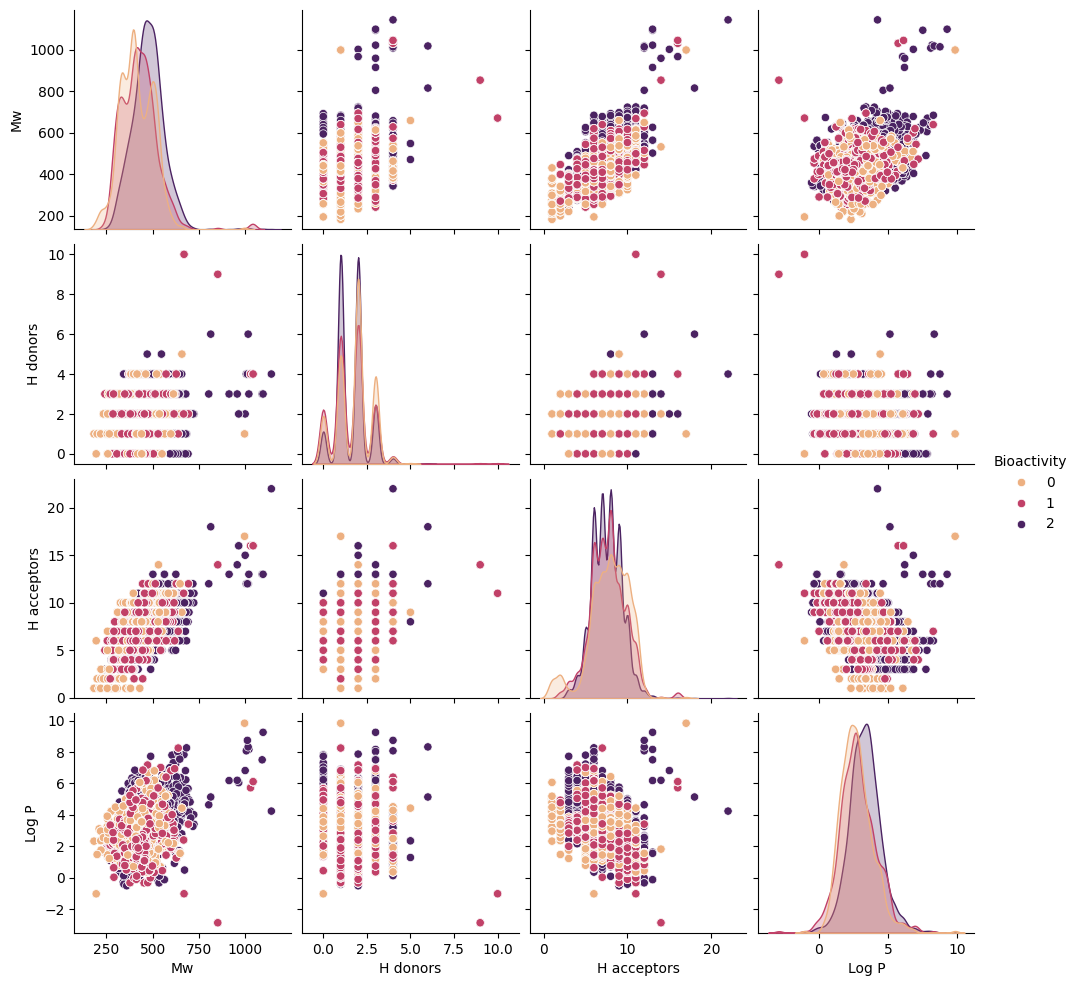

In [28]:
#plt.figure(figsize=(5.5, 5.5))
#sns.color_palette("flare")
#sns.countplot(x='Bioactivity', hue = 'Bioactivity', data=df_lipinski, edgecolor='black', palette = "flare")

#plt.xlabel('Bioactivity', fontsize=14, fontweight='bold')
#plt.ylabel('Frequency', fontsize=14, fontweight='bold')

descriptors = ['Mw', 'H donors', 'H acceptors', 'Log P']
sns.pairplot(df_lipinski[descriptors + ['Bioactivity']], hue="Bioactivity", palette = "flare")

It is visible that the inactive, partially active and active labeled molecule share a huge overlap, using the Lipinski descriptors may not offer the best features to separate them properly.

The number of Lipinski descriptors is limited and so even if we began with them, we decided to the rdkit package and its descriptors which are more than 200

## Definition of the rdkit descriptor

In [32]:
df_descriptor = descriptor_df(df)

In [33]:
df_descriptor
df_descriptor.to_csv('df_descriptor.csv', index=False)

# Data preparation for the models:

We tried to make a reduction of dimensionality to 2, for a better visualization of the dataset with the rdkit descriptors, as the following graph displays:

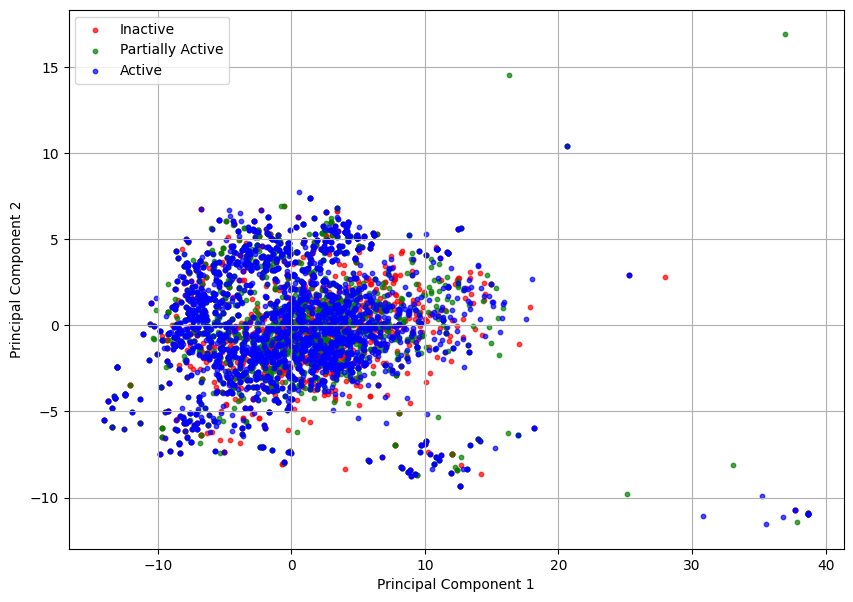

In [34]:
from sklearn.decomposition import PCA
X_train, X_test, Y_train, Y_test= data_prep(df_descriptor)

np.random.seed(100)


pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_train)

df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['target'] = Y_train
target_names = ['Inactive', 'Partially Active', 'Active']

# Plot the PCA
plt.figure(figsize=(10, 7))
colors = ['r', 'g', 'b']
for target, color, target_name in zip([-1, 0, 1], colors, target_names):
    indices_to_keep = df_pca['target'] == target
    plt.scatter(df_pca.loc[indices_to_keep, 'PC1'], df_pca.loc[indices_to_keep, 'PC2'], c=color, s=10, alpha=0.7, label=target_name)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(target_names)
plt.grid()

# Show the plot
plt.show()

... But the various bioactivities overlap too much if we limit the number of dimension to 2. Unfortunately, no visible separation is present in the precedent plot (even a non-attentive readeer would have notice it).

# Model Construction and Optimization

## Classification model

### Optimization of the Full-Connected Neural Network

Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

/Users/keliangaedecke/opt/anaconda3/envs/myenv/lib/python3.9/multiprocessing/resource_tracker.py:96: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '
Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


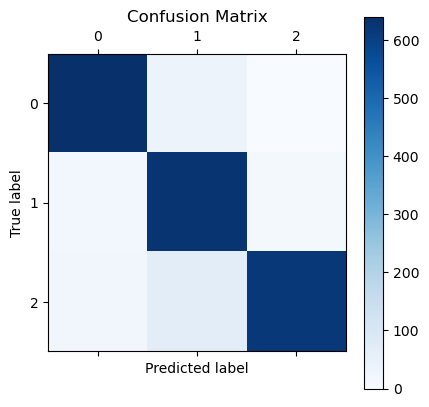

Best Hyperparameters for Feedforward Neural Network: {'activation': 'relu', 'alpha': 0.45055420204434604, 'learning_rate_init': 0.0023132311548267866}
Best Parameters {'activation': 'relu', 'alpha': 0.45055420204434604, 'learning_rate_init': 0.0023132311548267866} Test accuracy: 0.9240940254652301


In [ ]:
best_params_fcn,test_accuracy_fcn = optimize_hyperparameters_random_search(df_descriptor, 'fcn')
print("Best Hyperparameters for Feedforward Neural Network:", best_params_fcn)
print("Best Parameters", best_params_fcn,"Test accuracy:",test_accuracy_fcn)

### Optimization of the RandomForest

Test Accuracy: 0.9618021547502449
Test Precision: 0.9636213720111061
Test Recall: 0.9618021547502449
Test F1 Score: 0.9616286993453186
Confusion Matrix:
 [[631   7   0]
 [  8 694   0]
 [ 20  43 639]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.96      0.99      0.97       638
           0       0.93      0.99      0.96       702
           1       1.00      0.91      0.95       702

    accuracy                           0.96      2042
   macro avg       0.96      0.96      0.96      2042
weighted avg       0.96      0.96      0.96      2042



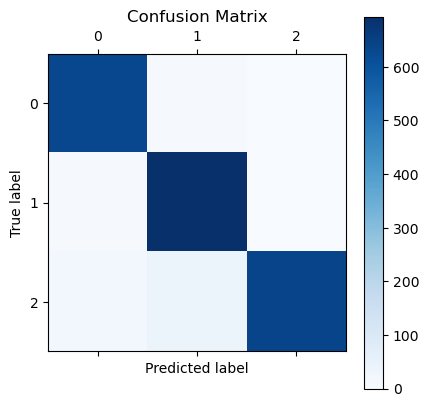

Best Hyperparameters for RF: {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 413}
Best Parameters {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 413} Test accuracy: 0.9618021547502449


In [ ]:
best_params_rf,test_accuracy_rf = optimize_hyperparameters_random_search(df_descriptor, 'rf')
print("Best Hyperparameters for RF:", best_params_rf)
print("Best Parameters", best_params_rf,"Test accuracy:",test_accuracy_rf)

### Optimization of the Support Vector Machine

Test Accuracy: 0.9897159647404505
Test Precision: 0.9897951284523908
Test Recall: 0.9897159647404505
Test F1 Score: 0.9897297711986829
Confusion Matrix:
 [[658   7   0]
 [  5 682   0]
 [  3   6 681]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.99      0.99      0.99       665
           0       0.98      0.99      0.99       687
           1       1.00      0.99      0.99       690

    accuracy                           0.99      2042
   macro avg       0.99      0.99      0.99      2042
weighted avg       0.99      0.99      0.99      2042



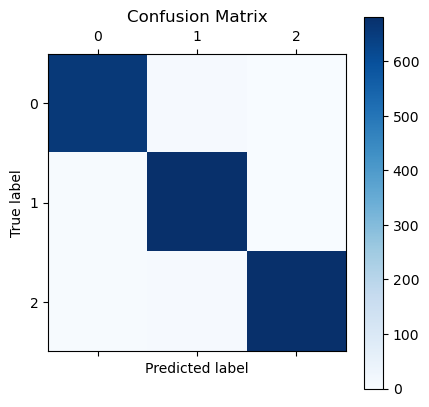

Best Hyperparameters for SVM: {'C': 9.795846277645586, 'gamma': 0.7851328233611146, 'kernel': 'rbf'}
Best Parameters {'C': 9.795846277645586, 'gamma': 0.7851328233611146, 'kernel': 'rbf'} Test accuracy: 0.9897159647404505


In [ ]:
best_params_svm,test_accuracy_svm = optimize_hyperparameters_random_search(df_descriptor, 'svm')
print("Best Hyperparameters for SVM:", best_params_svm)
print("Best Parameters", best_params_svm,"Test accuracy:",test_accuracy_svm)

# Construction of the Ensemble Model

## RandomForest model training

In [ ]:
#rf_param = RandomForestClassifier(**best_params_rf)
#Best Parameters {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 413}
rf_param = {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 413}

rf = RandomForestClassifier(**rf_param)
rf.fit(X_train, Y_train)
pred_rf = rf.predict(X_test)


## Support Vector Machine model training

In [ ]:
#svm_param = GradientBoostingClassifier(**best_params_gbm)
#Best Parameters {'C': 9.795846277645586, 'gamma': 0.7851328233611146, 'kernel': 'rbf'}
svm_param = {'C': 9.795846277645586, 'gamma': 0.7851328233611146, 'kernel': 'rbf'}

svm = SVM(**svm_param)
svm.fit(X_train, Y_train)
pred_rf = rf.predict(X_test)

## Full Connected Neural Network model training

In [ ]:
#fcn_params = best_params_fcn
#Best Parameters {'activation': 'relu', 'alpha': 0.45055420204434604, 'learning_rate_init': 0.0023132311548267866}
#fcn_params = {'activation': 'relu', 'alpha': 0.45055420204434604, 'learning_rate_init': 0.0023132311548267866}

activation_mapping = {
    'relu': nn.ReLU(),
}

class FCNN(nn.Module):
    def __init__(self, input_dim, activation):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)
        self.activation = activation

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

# Custom loss function to handle labels -1, 0, 1
class CustomCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CustomCrossEntropyLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, input, target):
        # Mapping labels -1, 0, 1 to 0, 1, 2
        target = target + 1
        return self.ce_loss(input, target)


X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)

net = NeuralNetClassifier(
    module=FCNN,
    module__input_dim=X_train.shape[1],
    module__activation=activation_mapping['relu'],
    max_epochs=50,
    lr=0.0023132311548267866,
    batch_size=32,
    optimizer=optim.Adam,
    criterion=CustomCrossEntropyLoss,
    iterator_train__shuffle=True,
    verbose=0
)

y_true_encoded = Y_train.astype(np.int64)

net.fit(X_train.astype(np.float32), y_true_encoded)

pred_fcnn = net.predict(X_test.astype(np.float32))

#predictions from [0, 1, 2] back to [-1, 0, 1]
pred_fcnn_original = pred_fcnn - 1

print("True labels:", y_true_encoded)
print("Predicted labels:", pred_fcnn_original)
print("Accuracy:", accuracy_score(Y_test, pred_fcnn_original))

In [36]:
class FCNN(nn.Module):
    def __init__(self, input_dim, activation):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)
        self.activation = activation

    def forward(self, x):
        x = x.float()
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

# Custom loss function to handle labels -1, 0, 1
class CustomCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CustomCrossEntropyLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, input, target):
        # Mapping labels -1, 0, 1 to 0, 1, 2
        target = target + 1
        return self.ce_loss(input, target)

# chose the right path if you want to use the downloaded model
#fcn = load('/Users/keliangaedecke/Desktop/Git/DDIP/PPchem_DDIP/models/fcn_model.joblib')
#rf = load('/Users/keliangaedecke/Desktop/Git/DDIP/PPchem_DDIP/models/rf_model.joblib')
#svm = load('/Users/keliangaedecke/Desktop/Git/DDIP/PPchem_DDIP/models/svm_model.joblib')

fcn = load('/content/fcn_model.joblib')
rf = load('/content/rf_model.joblib')
svm = load('/content/svm_model.joblib')

pred_fcnn = fcn.predict(X_test.astype(np.float32))
pred_fcnn = pred_fcnn -1

pred_rf = rf.predict(X_test)

pred_svm = svm.predict(X_test)



# Test of the models

## Confusion matrix

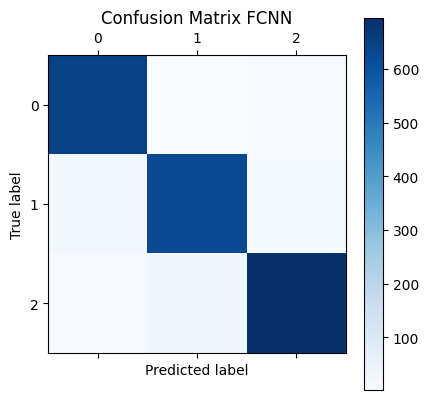

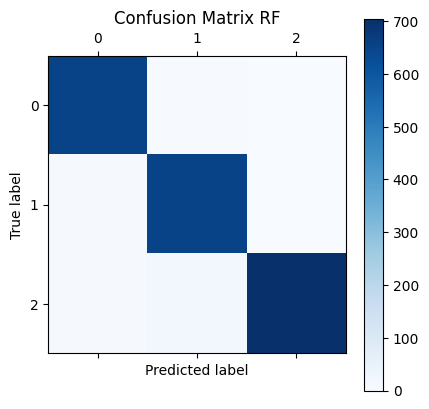

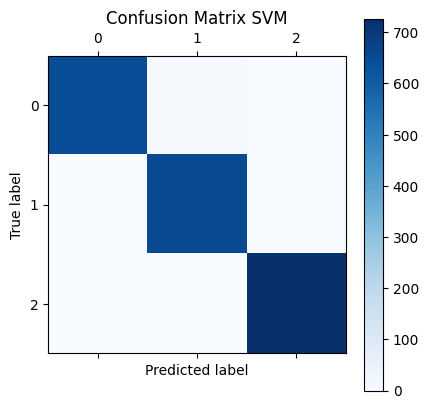

In [53]:
cm_fcnn = confusion_matrix(Y_test, pred_fcnn)
cm_rf = confusion_matrix(Y_test, pred_rf)
cm_svm = confusion_matrix(Y_test, pred_svm)

plt.matshow(cm_fcnn, cmap=plt.cm.Blues)
plt.title('Confusion Matrix FCNN')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

plt.matshow(cm_rf, cmap=plt.cm.Blues)
plt.title('Confusion Matrix RF')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

plt.matshow(cm_svm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix SVM')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

As we saw also before, while optimizing the parameters, the confusion matrix displays a very good prediction, this is clearly visible by the "populated" diagonal, compared to the "empty" off diagonal.

## ROC plot

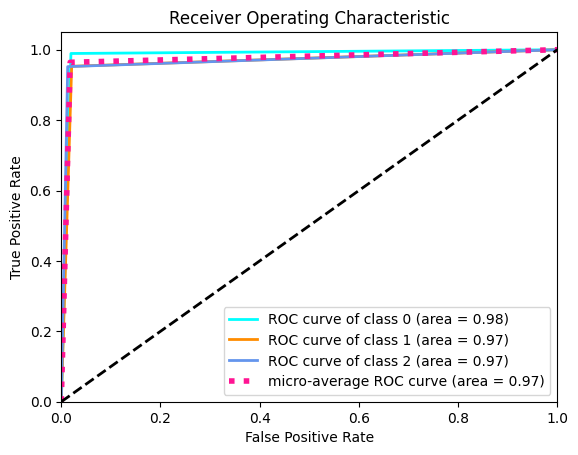

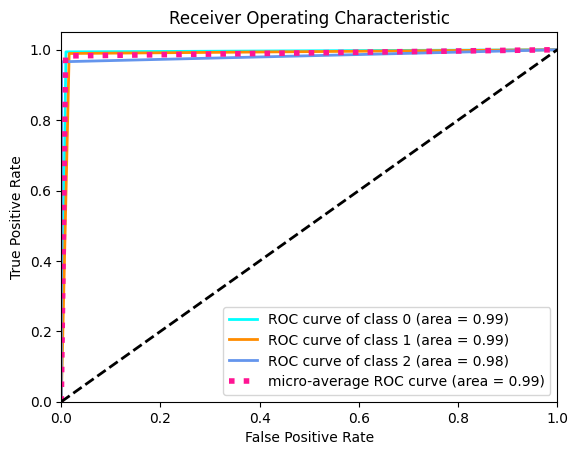

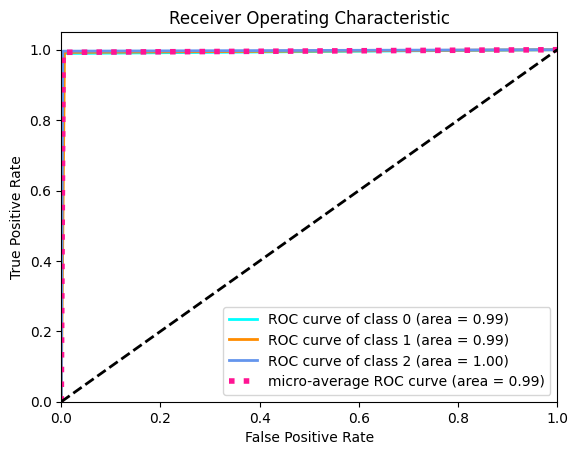

In [49]:
n_classes = 3

# Convert the predicted labels to one-hot encoding to simulate probabilities
pred_fcnn_proba = label_binarize(pred_fcnn + 1, classes=list(range(n_classes)))
pred_rf_proba = label_binarize(pred_rf + 1, classes=list(range(n_classes)))
pred_svm_proba = label_binarize(pred_svm + 1, classes=list(range(n_classes)))

plot_multiclass_roc(Y_test + 1, pred_fcnn_proba, n_classes=3)
plot_multiclass_roc(Y_test + 1, pred_rf_proba, n_classes=3)
plot_multiclass_roc(Y_test + 1, pred_svm_proba, n_classes=3)


One can clearly see that the models fit very well the test data, the number of true positive is near 100 % while the number of false positive is close to 0 %.


## F1-score

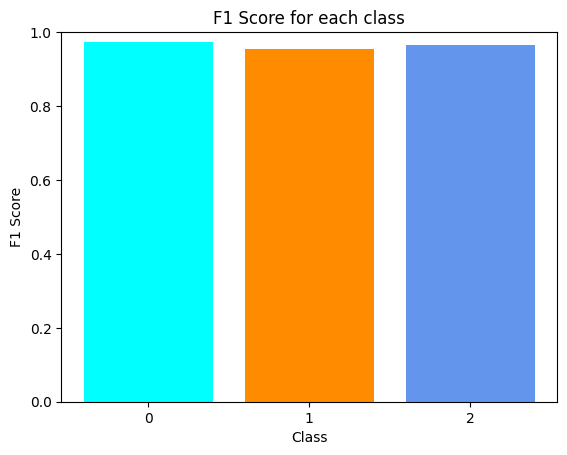

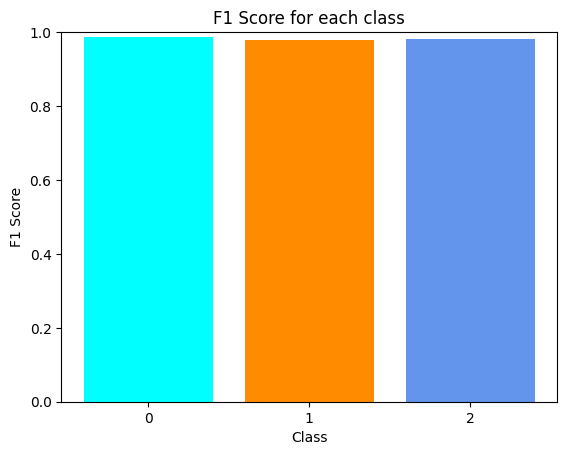

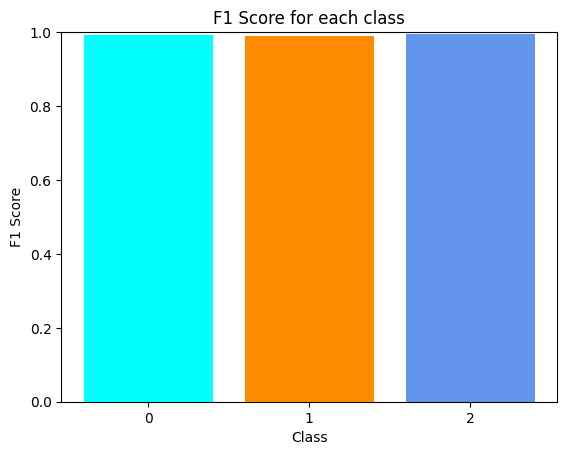

In [51]:
plot_f1_scores(pred_fcnn, Y_test, 3)
plot_f1_scores(pred_rf,Y_test ,3)
plot_f1_scores(pred_svm, Y_test,3)

It is also visible that the prediction of each model achieve a very good F1 score. The f1 score use multiple metrics:
- Precision = True Positives / (True Positives + False Positives)
- Recall = True Positives / (True Positives + False Negatives)
- F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

One can see that SVM displays better performance than the FCNN and the RF models, while they still displays a very good performance still.

## definition of the functions

In [50]:
##### DEFINITION OF A FUNCTION ####

def data_cleaner(dataframe):
    """
    dataframe: dataframe of all the candidate proteins

    The function only keep the entries of interest: 'molecule_chembl_id','canonical_smiles','standard_value'
    and also get rid of the incomplete data

    """
    dataframe = dataframe = dataframe[['molecule_chembl_id','canonical_smiles','standard_value']]
    dataframe_cleaned = dataframe[dataframe.standard_value.notna()]
    dataframe_cleaned = dataframe_cleaned[dataframe.canonical_smiles.notna()]
    dataframe_cleaned = dataframe_cleaned.drop_duplicates(['canonical_smiles'])

    return dataframe_cleaned

##### DEFINITION OF A FUNCTION ####

def add_bioactivity(dataframe):
    """
    dataframe: (cleaned) dataframe of all the candidate proteins

    The function labels the molecules as inactive, partialy active or active depending on their standard value
    """
    bioactivity = []
    for i in dataframe.standard_value:
      if float(i) >= 10000:
        bioactivity.append(0) #inactive
      elif float(i) <= 1000:
        bioactivity.append(2) #active
      else:
        bioactivity.append(1) #depends
    dataframe['Bioactivity'] = bioactivity
    dataframe.reset_index(drop=True, inplace=True)
    return dataframe


##### DEFINITION OF A FUNCTION ####

def lipinski(smiles):
    """
    smile: smile (column)

    The function calculate the Lipinski descriptors from the smiles, the Lipinski descriptors are the MW, the LogP (solubility),
    the number of H donors and the number of H acceptors

    """


    molec = []
    for i in smiles:
        mol = Chem.MolFromSmiles(i)
        molec.append(mol)

    MW = []
    LogP = []
    NHDonors = []
    NHAcceptors = []

    for n in molec:
        MW.append(Descriptors.MolWt(n))
        LogP.append(Descriptors.MolLogP(n))
        NHDonors.append(Lipinski.NumHDonors(n))
        NHAcceptors.append(Lipinski.NumHAcceptors(n))

    desc_data = pd.DataFrame({
        "Mw": MW,
        "H donors": NHDonors,
        "H acceptors": NHAcceptors,
        "Log P": LogP
    })

    return desc_data

def norm_value(input):
    """
    input: clean dataframe of the candidate molecules

    The function cnormalize the standard value

    """

    norm = []

    for i in input['standard_value']:
        if i > 100000000:
            i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop(columns=['standard_value'])  # Drop the 'standard_value' column

    return x

def pIC50(input):
    """
    input: clean dataframe of the candidate molecules

    The function calculate and add the pIC50 (a measure of bioactivity)

    """

    if 'standard_value_norm' not in input.columns:
        raise ValueError("Column 'standard_value_norm' does not exist in the DataFrame.")

    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i * (10**-9)  # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop(columns=['standard_value_norm'])  # Drop the 'standard_value' column

    return x


def lipinski_df(dataframe):
    """
    dataframe: clean dataframe of the candidate molecules

    The function calculate and add the the Lipinski descriptors, normalize the standard values and the pIC50

    """


    dataframe_lipinski = pd.concat([dataframe, lipinski(dataframe.canonical_smiles)], axis = 1)
    dataframe_lipinski['standard_value'] = pd.to_numeric(dataframe_lipinski['standard_value'], errors='coerce')
    dataframe_lipinski = dataframe_lipinski.loc[pd.notna(dataframe_lipinski['standard_value'])]
    dataframe_lipinski = norm_value(dataframe_lipinski)
    dataframe_lipinski = pIC50(dataframe_lipinski)

    return dataframe_lipinski

#### DEFINITION FUNCTION ####

def descriptors(smiles):
    """
    smile: smile (column)

    The function calculate the rdkit descriptors from the smiles, the rdkit descriptors are composed of a lot of different descriptors

    """

    mols = []

    for i in smiles:
        molec = Chem.MolFromSmiles(i)
        mols.append(molec)
    descrs = [Descriptors.CalcMolDescriptors(mol) for mol in mols]
    df_descr = pd.DataFrame(descrs)

    return df_descr

def descriptor_df(dataframe):
    """
    dataframe: clean dataframe of the candidate molecules

    The function calculate and add the the rdkit descriptors, normalize the standard values and the pIC50

    """



    dataframe_descriptors = pd.concat([dataframe, descriptors(dataframe.canonical_smiles)], axis = 1)
    dataframe_descriptors['standard_value'] = pd.to_numeric(dataframe_descriptors['standard_value'], errors='coerce')
    dataframe_descriptors = dataframe_descriptors.loc[pd.notna(dataframe_descriptors['standard_value'])]
    dataframe_descriptors = norm_value(dataframe_descriptors)
    dataframe_descriptors = pIC50(dataframe_descriptors)

    #dataframe_descriptors.replace([np.inf, -np.inf], np.nan, inplace=True)
    dataframe_descriptors.dropna(inplace=True)
    dataframe_descriptors.reset_index(drop=True, inplace=True)

    return dataframe_descriptors


def data_split_scale(X,Y):

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, Y_train, Y_test


def data_prep(dataframe):
    """
    dataframe: clean dataframe of the candidate molecules with the descriptors

    The function remove the 'molecule_chembl_id', 'pIC50' and 'canonical_smiles', it centers the labels around zero. It separates
    the features in a 'X' matrix and the bioactivity label in a 'Y' vector. Also keep the features with a sufficient threshold and
    then split the data into a training set and a test set.

    """


    dataframe = dataframe.drop('molecule_chembl_id', axis=1)
    dataframe = dataframe.drop('pIC50', axis=1)
    dataframe = dataframe.drop('canonical_smiles', axis=1)
    dataframe['Bioactivity'] = dataframe['Bioactivity'] - 1


    selection = VarianceThreshold(threshold=(.9 * (1 - .3)))

    X = dataframe.drop('Bioactivity', axis=1)
    X = selection.fit_transform(X)
    Y = dataframe['Bioactivity']

    X_train, X_test, Y_train, Y_test = data_split_scale(X,Y)

    return X_train, X_test, Y_train, Y_test

def data_split_scale(X,Y):
    """
    X: features of the data
    Y: label of the data

    The function split the data into a test and a training set and scale the features on the training set.
    """

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, Y_train, Y_test

def plot_multiclass_roc(y_test, y_score, n_classes):
    """
    y_test: true features of the test data
    y_score

    The function create a plot of the ROC curve for multiclass.
    """

    y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'darkred'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(i, roc_auc[i]))

    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def optimize_hyperparameters_random_search(dataframe, model_type):
    """
    dataframe: clean dataframe of the candidate molecules with the descriptors
    model_type: 'rf', 'svm', or 'fcn'

    The function does the data preparation and then trains the chosen model using a randomized search.
    The model is then evaluated using accuracy, precision, recall, F1 Score, and confusion matrix.
    The best parameter found are then returned.
    """

    X_train, X_test, y_train, y_test = data_prep(dataframe)
    np.random.seed(100)

    if model_type == 'rf':
        model = RandomForestClassifier()
        param_space = {
            'n_estimators': randint(100, 500),
            'max_depth': randint(5, 50),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 20),
        }
    elif model_type == 'svm':
        model = SVC(probability=True)
        param_space = {
            'C': uniform(0.1, 10),
            'gamma': uniform(0.01, 1),
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        }
    elif model_type == 'fcn':
        model = MLPClassifier(hidden_layer_sizes=(100,), solver='adam')
        param_space = {
            'activation': ['relu', 'tanh', 'logistic'],
            'alpha': uniform(0.0001, 0.9999),
            'learning_rate_init': uniform(0.001, 0.099),
        }
    else:
        raise ValueError("Invalid model_type. Choose 'rf', 'svm', or 'fcn'.")

    opt = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_space,
        n_iter=25,
        cv=5,
        n_jobs=-1,
        scoring='accuracy',
        verbose=0,
        random_state=42,
    )

    opt.fit(X_train, y_train)
    best_params = opt.best_params_
    best_model = opt.best_estimator_
    y_pred = best_model.predict(X_test)
    y_score = best_model.predict_proba(X_test)

    test_accuracy = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred, average='weighted')
    test_recall = recall_score(y_test, y_pred, average='weighted')
    test_f1 = f1_score(y_test, y_pred, average='weighted')

    print("Test Accuracy:", test_accuracy)
    print("Test Precision:", test_precision)
    print("Test Recall:", test_recall)
    print("Test F1 Score:", test_f1)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.matshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


    return best_params, test_accuracy

def randomize_smiles(smiles):
    """
    Generate a randomized SMILES string
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return Chem.MolToSmiles(mol, doRandom=True)

def augment_data(df, num_augments=5):
    augmented_data = []

    for idx, row in df.iterrows():
        smiles = row['canonical_smiles']
        for _ in range(num_augments):
            random_smiles = randomize_smiles(smiles)
            if random_smiles:
                augmented_row = row.copy()
                augmented_row['canonical_smiles'] = random_smiles
                augmented_data.append(augmented_row)

    augmented_df = pd.DataFrame(augmented_data)
    return augmented_df

def plot_f1_scores(y_pred, y_test , n_classes):
    """
    y_pred: predicted label
    y_test: true label
    n_classes: number of classes
    """

    f1_scores = f1_score(y_test, y_pred, average=None)
    plt.figure()
    classes = list(range(n_classes))
    plt.bar(classes, f1_scores, color=['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'darkred'][:n_classes])
    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    plt.title('F1 Score for each class')
    plt.xticks(classes)
    plt.ylim([0.0, 1.0])
    plt.show()


